In [40]:
## data from kaggle : 


# /kaggle/input/covid-19-nlp-text-classification



!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import os 
import tensorflow as tf 
import re 
import string
import nltk 
# import emoji 
import warnings 
warnings.simplefilter('ignore')



from sklearn import preprocessing 
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split 

#Naive Bayes 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB



from transformers import BertTokenizerFast 
from transformers import TFBertModel 
from transformers import RobertaTokenizerFast 
from transformers import TFRobertaModel

from tensorflow import keras 


from sklearn.metrics import f1_score ,accuracy_score 
from sklearn.metrics import classification_report , confusion_matrix


seed = 42 


# set style for our plot 

sns.set_style("whitegrid")
sns.despine()
plt.style.use('seaborn-whitegrid')
plt.rc('figure' , autolayout =True)
plt.rc('axes' , labelweight ='bold' ,labelsize ='large', titleweight ='bold' ,titlepad =10)



<Figure size 432x288 with 0 Axes>

# load data

In [42]:
train_data = pd.read_csv('/content/Corona_NLP_train.csv' ,
                         encoding='ISO-8859-1')
test_data = pd.read_csv('/content/Corona_NLP_train.csv' , encoding='ISO-8859-1')


In [43]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [44]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [45]:
train_data.Sentiment.value_counts()


Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [46]:
train_data['TweetAt'] = pd.to_datetime(train_data['TweetAt'])

In [47]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# Ploting 

In [48]:
tweets_per_day = train_data['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name ='count')

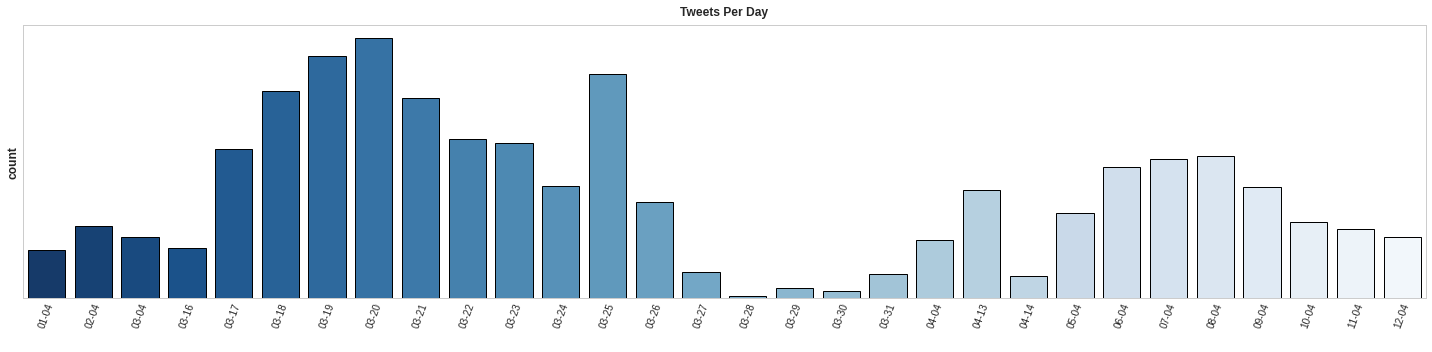

In [49]:
plt.figure(figsize=(20,5))
ax = sns.barplot(data=tweets_per_day , x ='index' , y ='count' , edgecolor='black' ,
                ci=False, palette='Blues_r')

plt.title('Tweets Per Day')
plt.xticks(rotation=70)
plt.yticks([])
plt.ylabel('count')
plt.xlabel(' ')
plt.show()

In [50]:
# Tweets per country
tweets_per_country  = train_data['Location'].value_counts().loc[lambda x:x>100].reset_index(name ='count')
tweets_per_country.head()

,index,count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373


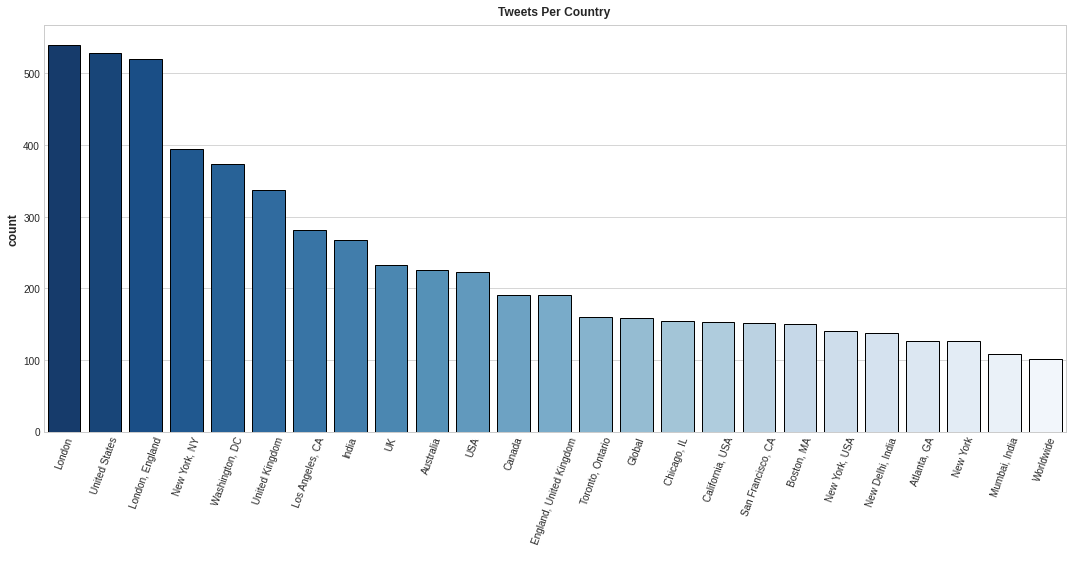

In [51]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data = tweets_per_country ,x ='index' , y ='count' , edgecolor = 'black' ,
                 palette='Blues_r')


plt.xticks(rotation=70)
plt.xlabel(' ')
plt.ylabel('count')
plt.title('Tweets Per Country')
plt.show()

In [52]:
## for simplifing data for processing it 


df = train_data[['OriginalTweet' , 'Sentiment']]
df_test = test_data[['OriginalTweet' , 'Sentiment']]

In [53]:
## our main goal ['OriginalTweet'] 
## then we can use map function to process ['Sentiment'] colomn 


## here we go to make our functions to process our data 

#Remove punctuations, links, mentions and \r\n new line characters
def remove_punctuation(text):
    text = text.replace('\r' ,'').replace('\n' ,' ').replace('\n', ' ').lower()
    #remove \n and \r and lowercase
    #remove links and mentions:-
    text = re.sub(r'(?:\@|https?\://)\S+' , '' ,text)
    #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text =re.sub(r'[^\x00-\x7f]' ,'' ,text)
    #remove punctuations 
    banned_list = string.punctuation +'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§' 
    table = str.maketrans('','',banned_list)
    text = text.translate(table)
    return text 

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the 
# symbol
def remove_hashtage(text):
    #remove last hashtags
    new_tweet = ' '.join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)' 
                                                           ,text))
    #remove hashtags symbol from words in the middle of the sentence
    new_text = ' '.join(word.strip() for word in re.split('#|_' ,new_tweet))
    return new_text 

    
def multi_spcae(text):
    return re.sub('\s\s+' ,' ' ,text)

#Filter special characters such as & and $ present in some words
def filter_char(text):
    
    filtering =[]
    for word in text.split():
        if ('$'in word) or ('&' in word):
            filtering.append(' ')
        else :
            filtering.append(word)
    return ' '.join(filtering)
        

In [54]:
train_text =[]
test_text =[]

for tweet in df.OriginalTweet :
    train_text.append(multi_spcae(filter_char(remove_hashtage(remove_punctuation(tweet)))))

for tweet in df_test.OriginalTweet :
    test_text.append(multi_spcae(filter_char(remove_hashtage(remove_punctuation(tweet)))))


In [55]:
df['clean_text'] =train_text
df_test['clean_text'] = test_text

In [56]:
df.head()

,OriginalTweet,Sentiment,clean_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...


In [57]:
df_test.head()

,OriginalTweet,Sentiment,clean_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...


In [58]:
# creat column to check the  length of sentence or tweet 
train_length = []
test_length  = []


for t in df.clean_text :
    train_length.append(len(t.split()))
    
for t in df_test.clean_text :
    test_length.append(len(t.split()))




In [59]:
df['length'] = train_length
df_test['length'] = test_length

In [60]:
df.head()

,OriginalTweet,Sentiment,clean_text,length
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and,2
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...,13
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...,41
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...,39


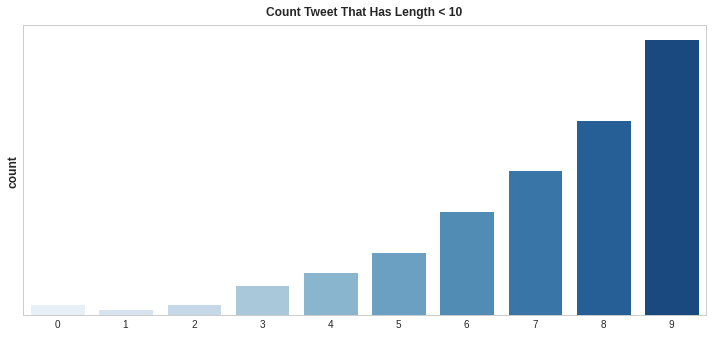

In [61]:
plt.figure(figsize=  (10,5)) 
ax = sns.countplot(x = 'length'  ,data = df[df['length'] <10] , palette='Blues' )

plt.yticks([])
plt.ylabel('count')
plt.title('Count Tweet That Has Length < 10')
plt.xlabel(' ')
plt.show()

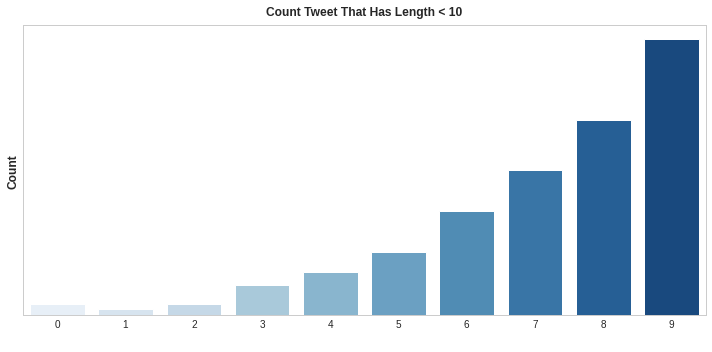

In [62]:
plt.figure(figsize = (10,5))
ax = sns.countplot(data = df_test[df_test['length'] < 10] , x = 'length' , palette= 'Blues')

plt.yticks([])
plt.title('Count Tweet That Has Length < 10')
plt.ylabel('Count')
plt.xlabel(' ')
plt.show()

In [63]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [64]:
tokens_length  = []
for tweet in df.clean_text.values :
    tokens = tokenizer.encode(tweet , max_length= 512,truncation =True)
    tokens_length.append(len(tokens))
    
max_length = max(tokens_length)
    

In [65]:
max_length

100

In [66]:
test_tokens_length = []


for tweet in df_test.clean_text.values :
    tokens = tokenizer.encode(tweet , max_length = 512 , truncation =True)
    test_tokens_length.append(len(tokens))
    
    
max_test = max(test_tokens_length)

In [67]:
max_test

100

In [68]:
df['tokens_length'] = tokens_length
df_test['tokens_length'] = test_tokens_length

In [69]:
df.head()

,OriginalTweet,Sentiment,clean_text,length,tokens_length
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and,2,4
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...,38,42
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...,13,20
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...,41,57
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...,39,56


In [70]:
df = df.sort_values(by ='tokens_length' , ascending =False)
df_test = df_test.sort_values(by = 'tokens_length' ,ascending =False)

In [71]:
df.head()

,OriginalTweet,Sentiment,clean_text,length,tokens_length
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80


In [72]:
### here we process our output to make it numerical not categorical 

df['Sentiment'] = df['Sentiment'].map({'Negative':0 ,'Extremely Negative':0 , 'Neutral':1 ,'Positive':2 ,
                                      'Extremely Positive':2})
df_test['Sentiment'] =df_test['Sentiment'].map({'Negative':0 ,'Extremely Negative':0 , 'Neutral':1 ,'Positive':2 ,
                                      'Extremely Positive':2}) 

In [73]:
df.head()

,OriginalTweet,Sentiment,clean_text,length,tokens_length
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,1,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,1,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,1,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,1,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
28899,Kindly contact Us bamy global merchandise for ...,2,kindly contact us bamy global merchandise for ...,37,80


# Balanced with Random Over Sampling

main idea is make balanced between data if we showing data for you you will focused that data in column Sentiment are not equal

In [74]:
df.Sentiment.value_counts()

2    18046
0    15398
1     7713
Name: Sentiment, dtype: int64

In [75]:
#creat object  :::::---->
ROS = RandomOverSampler()
X_train , y_train = ROS.fit_resample(np.array(df['clean_text']).reshape(-1,1) , 
                                     np.array(df['Sentiment']).reshape(-1,1))
X_test , y_test = ROS.fit_resample(np.array(df_test['clean_text']).reshape(-1,1) , 
                                  np.array(df_test['Sentiment']).reshape(-1,1))


In [76]:
train_ROS = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), 
                         columns = ['clean_text', 'Sentiment']) 
test_ROS = pd.DataFrame(list(zip([x[0] for x in X_test] ,y_test )) , 
                       columns = ['clean_text'  , 'Sentiment'])

In [77]:
## our result is :-->

train_ROS.Sentiment.value_counts()

1    18046
2    18046
0    18046
Name: Sentiment, dtype: int64

In [78]:
test_ROS.Sentiment.value_counts()

1    18046
2    18046
0    18046
Name: Sentiment, dtype: int64

# spliting data into train and validation data

In [79]:
X = train_ROS.clean_text.values
y = train_ROS.Sentiment.values
X_test = test_ROS.clean_text.values
y_test = test_ROS.Sentiment.values
X_train , X_valid , y_train , y_valid = train_test_split(X , y ,test_size =0.1 , random_state =42)

# One hot encoder

In [80]:
## one hot encoder doing best with this state and classification state Generally
# processing focused in label columns it is Sentiment columns
# taking copy of our labels :


y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
y_test_copy  = y_test.copy()

In [81]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_train_encoder = encoder.fit_transform(np.array(y_train_copy).reshape(-1,1)).toarray()
y_valid_encoder = encoder.fit_transform(np.array(y_valid_copy).reshape(-1,1)).toarray()
y_test_encoder  = encoder.fit_transform(np.array(y_test_copy).reshape(-1,1)).toarray()

In [82]:
# CountVetorizer

CV_model = CountVectorizer()
X_train_cv = CV_model.fit_transform(X_train) 
X_valid_cv = CV_model.transform(X_valid)
X_test_cv  = CV_model.transform(X_test)


In [83]:
TFIDF_model = TfidfTransformer(use_idf=True)
X_train_TF = TFIDF_model.fit_transform(X_train_cv) 
X_valid_TF = TFIDF_model.transform(X_valid_cv)
X_test_TF  = TFIDF_model.transform(X_test_cv)

# naive byese model

In [84]:
NB_model = MultinomialNB()

## training our model 

NB_model.fit(X_train_TF ,y_train_copy)


MultinomialNB()

In [85]:
prediction = NB_model.predict(X_test_TF)

In [86]:
# classification_report , confusion_matrix 

print(classification_report(prediction , y_test_copy)) 
print("\n\n******************************************\n\n")
print(confusion_matrix(prediction , y_test_copy))


              precision    recall  f1-score   support

           0       0.85      0.79      0.82     19457
           1       0.75      0.90      0.82     15123
           2       0.85      0.78      0.81     19558

    accuracy                           0.82     54138
   macro avg       0.82      0.82      0.82     54138
weighted avg       0.82      0.82      0.82     54138



******************************************


[[15363  2102  1992]
 [  741 13613   769]
 [ 1942  2331 15285]]


In [87]:
print(classification_report(y_test_copy,prediction, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.79      0.85      0.82     18046
     Neutral       0.90      0.75      0.82     18046
    Positive       0.78      0.85      0.81     18046

    accuracy                           0.82     54138
   macro avg       0.82      0.82      0.82     54138
weighted avg       0.82      0.82      0.82     54138



# Creat Our Model Bert

In [88]:
## first we need two main inputs for our model bert :
# 1- input_ids 
# 2- attention mask 
# 3- input_type_ids   is optionaly 
## to get this inputs we have use Tokenizer from transformers 
## let do it 

MAX_LENGTH =128
def Creat_our_inputs(data , tokenizer , max_length):
    input_ids =[]
    attention_mask=[]
    for i in range(len(data)):
        tokens = tokenizer.encode_plus( data[i] ,
                                      add_special_tokens =True ,
                                      return_attention_mask =True ,
                                      max_length = max_length ,
                                      padding = 'max_length')
        input_ids.append(tokens['input_ids'])
        attention_mask.append(tokens['attention_mask'])
    return np.array(input_ids) , np.array(attention_mask)



In [89]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [90]:
# each of it has two elements 1.input_ids 2.attention_mask

train_tokens = Creat_our_inputs(X_train ,tokenizer ,MAX_LENGTH)
valid_tokens = Creat_our_inputs(X_valid ,tokenizer ,MAX_LENGTH)
test_tokens  = Creat_our_inputs(X_test ,tokenizer ,MAX_LENGTH)

In [91]:
# spliting our data for preparation :

train_input_ids , train_attention_mask = train_tokens
valid_input_ids , valid_attention_mask = valid_tokens
test_input_ids  , test_attention_mask  = test_tokens
###################################


In [92]:
## now we can train our model 
BERT_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [93]:
## here we start impelementation our model :
def Creat_model(model ,max_length=MAX_LENGTH):
    input_ids = keras.Input(shape=(max_length ,) , dtype = tf.int32 ,name='input_ids')
    attention_mask =keras.Input(shape=(max_length, ) ,dtype=tf.int32 , name ='attention_mask')
    inputs = [input_ids ,attention_mask]
    
    ## layers 
    embedding = model(input_ids , attention_mask)[1]
    output = keras.layers.Dense(3 , activation ='softmax')(embedding)
    final_model = keras.models.Model(inputs=inputs ,outputs=output)
    return final_model  

In [94]:
model = Creat_model(BERT_model)

In [95]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

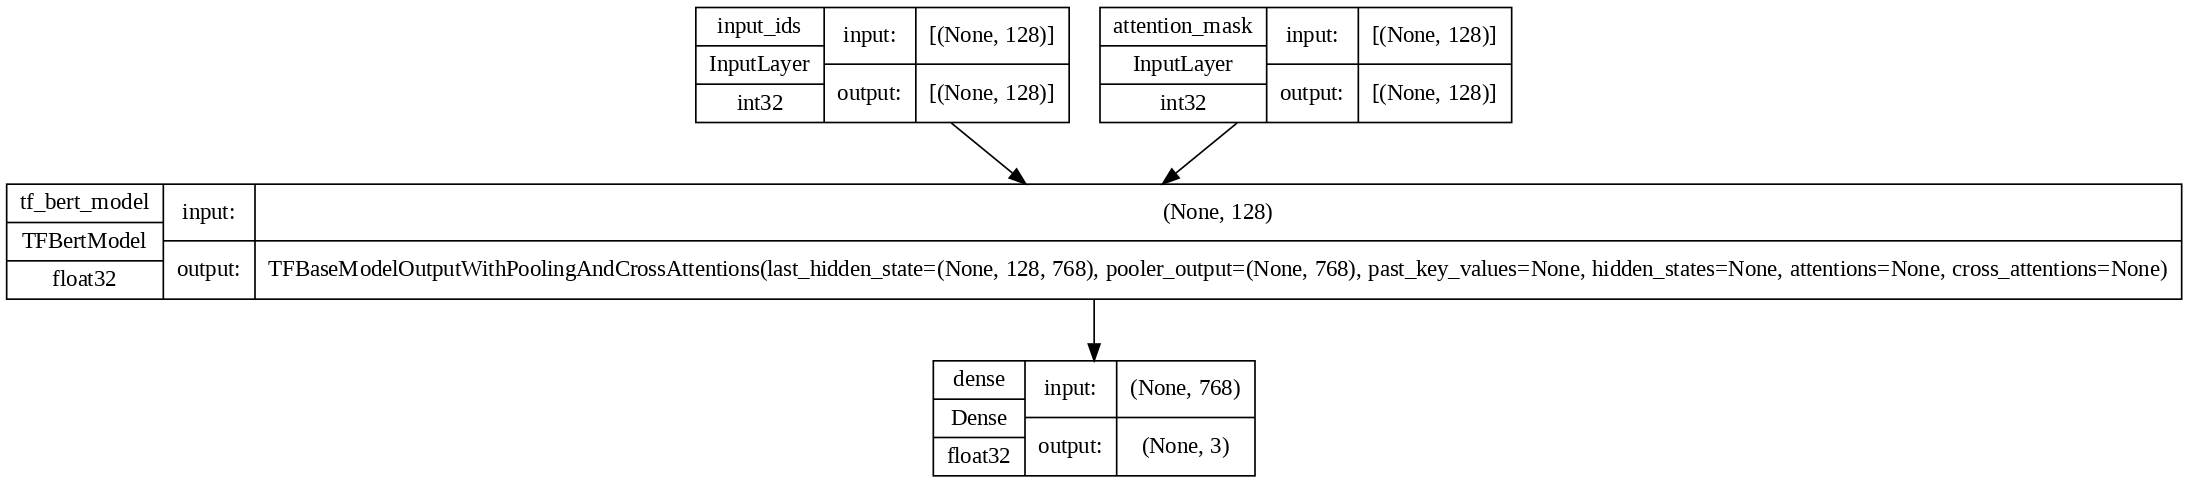

In [96]:
keras.utils.plot_model(model ,
                       show_shapes=True,
                        show_dtype=True,
                      dpi =120)

In [97]:
# compiling
optimizer = keras.optimizers.Adam(1e-5)
loss = keras.losses.CategoricalCrossentropy()
metrics = keras.metrics.CategoricalAccuracy()


model.compile(optimizer = optimizer , loss =loss , metrics =metrics)

In [ ]:
model.fit([train_input_ids , train_attention_mask ] , y_train_encoder ,
          validation_data = ([valid_input_ids , valid_attention_mask] , y_valid_encoder) , epochs =4 ,
         batch_size =32)

Epoch 1/4
1523/1523 [==============================] - 1232s 799ms/step - loss: 0.5544 - categorical_accuracy: 0.7775 - val_loss: 0.3374 - val_categorical_accuracy: 0.8803
Epoch 2/4
1523/1523 [==============================] - 1213s 797ms/step - loss: 0.2834 - categorical_accuracy: 0.8991 - val_loss: 0.2613 - val_categorical_accuracy: 0.9082
Epoch 3/4
1523/1523 [==============================] - 1213s 796ms/step - loss: 0.1869 - categorical_accuracy: 0.9363 - val_loss: 0.2253 - val_categorical_accuracy: 0.9241
Epoch 4/4
 882/1523 [================>.............] - ETA: 8:11 - loss: 0.1292 - categorical_accuracy: 0.9570